# Cell 0 - Accumulation Signal Sandbox
Explore alternate short-signal formulas using daily_metrics data (read-only). No database writes.

In [5]:
# Cell 1 - Imports and Configuration
from pathlib import Path
import sys

import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Find project root (darkpool/) from Special_tools/ location
notebook_dir = Path.cwd()
if notebook_dir.name == 'Special_tools':
    project_root = notebook_dir.parent
elif (notebook_dir / 'darkpool_analysis').exists():
    project_root = notebook_dir
else:
    # Walk up to find darkpool_analysis
    project_root = notebook_dir
    for _ in range(5):
        if (project_root / 'darkpool_analysis').exists():
            break
        project_root = project_root.parent

if (project_root / 'darkpool_analysis').exists():
    sys.path.insert(0, str(project_root))

from darkpool_analysis.config import load_config

config = load_config()

# =============================================================================
# USER CONFIGURATION
# =============================================================================

TICKER = 'VLO'
START_DATE = '2025-10-08'
END_DATE = '2026-01-06'
DB_PATH = config.db_path

DOT_MODE = 'current'  # 'current', 'option_a', 'option_b', 'all'
BLEND_SHORT_WEIGHT = 0.6
BLEND_FLOW_WEIGHT = 0.4

# Median-threshold settings
THRESHOLD_K = 1.5

# =============================================================================
# SIGNAL THRESHOLDS - Adjust these to tune signal sensitivity
# =============================================================================
# VWBR Z-Score threshold (for VWBR-Z signal row in heatmap and OHLC dots)
VWBR_Z_THRESHOLD = 1.1  # z >= 1.1 = accumulation, z <= -1.1 = distribution

# Z-Score to display scale factor (for VWBR-Z histogram panel)
# Formula: display = 50 + (z_score * VWBR_Z_SCALE_FACTOR)
# z=0 maps to 50, z=±5 fills the 0-100 range with scale=10
VWBR_Z_SCALE_FACTOR = 8

# Score thresholds for experiments A, B, C, D (0-100 scale)
SCORE_BUY_THRESHOLD = 70   # Score >= this = accumulation signal
SCORE_SELL_THRESHOLD = 30  # Score <= this = distribution signal

# =============================================================================
# EXPERIMENT DOT COLORS - Edit these to customize signal marker colors
# =============================================================================
# Each experiment can have separate colors for accumulation (buy) and distribution (sell) signals
# Format: {'buy': <color>, 'sell': <color>}
# Available colors: '#00ff88' (green), '#ff6b6b' (red), '#4aa3ff' (blue), 
#                   '#ffd700' (yellow), '#00d4ff' (cyan), '#b026ff' (purple), '#ff9f43' (orange)

EXPERIMENT_DOT_COLORS = {
    'VWBR_Z': {'buy': "#00ff0d", 'sell': "#f80000"}, # VWBR Z-Score (±1.1 threshold)
    'A': {'buy': "#00ff0d", 'sell': "#f80000"},      # Score A (VWBR composite)
    'B': {'buy': "#00ff0d", 'sell': "#f80000"},      # Score B (Short B/S Ratio - baseline)
    'C': {'buy': "#00ff0d", 'sell': "#f80000"},      # Score C (Combined)
    'D': {'buy': "#00ff0d", 'sell': "#f80000"},      # Score D (Imbalance)
    'Mean': {'buy': "#00ff0d", 'sell': "#f80000"},   # Mean consensus signals
}

# =============================================================================
# OHLC DOT DISPLAY MODE - Controls which experiment dots appear on OHLC chart
# =============================================================================
# Options:
#   'ALL'    - Show dots from all 5 signals (VWBR_Z + 4 experiments, vertically stacked)
#   'VWBR_Z' - Show only VWBR Z-Score dots (z >= 1.1 buy, z <= -1.1 sell)
#   'A'      - Show only Score A (VWBR composite) dots
#   'B'      - Show only Score B (Short B/S Ratio) dots
#   'C'      - Show only Score C (Combined) dots
#   'D'      - Show only Score D (Imbalance) dots
#   'Mean'   - Show single dot only if 3+ of the 5 signals agree (consensus signal)
#   'None'   - Hide all dots on OHLC chart
OHLC_DOT_DISPLAY = 'Mean'

In [6]:
# Cell 2 - Styling Constants and Helper Functions
import matplotlib.dates as mdates
from scipy.interpolate import PchipInterpolator

COLORS = {
    'background': '#0f0f10',
    'panel_bg': '#141416',
    'text': '#e6e6e6',
    'grid': '#2a2a2d',
    'white': '#ffffff',
    'green': '#00ff88',
    'red': '#ff6b6b',
    'yellow': '#ffd700',
    'cyan': '#00d4ff',
    'orange': '#ff9f43',
    'purple': '#b026ff',
    'neutral': '#6b6b6b',
    'blue': '#4aa3ff',
}
GRID_ALPHA = 0.18
OHLC_LINE_WIDTH = 1.2
SIGNAL_MARKER_SIZE = 60
SIGNAL_EDGE_WIDTH = 0.6
MAIN_LINE_WIDTH = 2.3
MARKER_SIZE = 25

def _apply_axis_style(ax):
    ax.set_facecolor(COLORS['panel_bg'])
    ax.tick_params(colors=COLORS['text'], labelsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(COLORS['grid'])
    ax.spines['bottom'].set_color(COLORS['grid'])
    ax.grid(True, alpha=GRID_ALPHA, color=COLORS['grid'], linestyle='--')

def _format_volume(value):
    if pd.isna(value):
        return 'NA'
    value = float(value)
    if abs(value) >= 1_000_000_000:
        return f'{value / 1_000_000_000:.1f}B'
    if abs(value) >= 1_000_000:
        return f'{value / 1_000_000:.1f}M'
    if abs(value) >= 1_000:
        return f'{value / 1_000:.0f}K'
    return f'{value:,.0f}'

def _rolling_zscore(series, window, min_periods):
    """Compute rolling z-score with safe division."""
    rolling = series.rolling(window=window, min_periods=min_periods)
    mean = rolling.mean()
    std = rolling.std(ddof=0)
    # Avoid division by zero: replace 0 std with NaN
    std = std.replace(0, np.nan)
    return (series - mean) / std

def _sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def _compute_score_display(short_z, lit_z, price_z, otc_z, cfg):
    short = pd.to_numeric(short_z, errors='coerce').to_numpy(dtype=float)
    lit = pd.to_numeric(lit_z, errors='coerce').fillna(0.0).to_numpy(dtype=float)
    price = pd.to_numeric(price_z, errors='coerce').fillna(0.0).to_numpy(dtype=float)
    otc = pd.to_numeric(otc_z, errors='coerce').fillna(0.0).to_numpy(dtype=float)

    score = np.full_like(short, np.nan, dtype=float)
    valid = ~np.isnan(short)
    if valid.any():
        raw = (
            cfg.composite_w_short * np.tanh(short[valid] * 0.5)
            + cfg.composite_w_lit * np.tanh(lit[valid] * 0.5)
            + cfg.composite_w_price * np.tanh(price[valid] * 0.3)
        )
        intensity_range = cfg.intensity_scale_max - cfg.intensity_scale_min
        intensity = cfg.intensity_scale_min + intensity_range * _sigmoid(otc[valid])
        score[valid] = np.clip(raw * intensity, -1.0, 1.0)

    display = (score + 1.0) * 50.0
    return pd.Series(display, index=short_z.index)

def _plot_smooth_line(ax, x_values, values, color, valid_mask, linewidth=MAIN_LINE_WIDTH, alpha=0.85, zorder=3):
    """Plot a smooth PCHIP-interpolated line through valid data points."""
    if valid_mask.sum() >= 3:
        valid_x = x_values[valid_mask]
        valid_values = values[valid_mask]

        x_nums = np.asarray(valid_x, dtype=float)
        x_smooth = np.linspace(x_nums.min(), x_nums.max(), 150)
        interp = PchipInterpolator(x_nums, valid_values.to_numpy() if hasattr(valid_values, 'to_numpy') else np.asarray(valid_values))
        y_smooth = interp(x_smooth)

        ax.plot(
            x_smooth,
            y_smooth,
            color=color,
            linewidth=linewidth,
            alpha=alpha,
            zorder=zorder,
        )
    else:
        ax.plot(
            x_values[valid_mask],
            values[valid_mask],
            color=color,
            linewidth=linewidth,
            alpha=alpha,
            zorder=zorder,
        )

def _set_flow_axis(ax, values):
    series = pd.to_numeric(values, errors='coerce')
    max_abs = series.abs().max(skipna=True)
    if pd.isna(max_abs) or max_abs == 0:
        max_abs = 1.0
    padding = max(max_abs * 0.1, 1.0)
    y_max = max_abs + padding
    y_min = -y_max
    ax.set_ylim(y_min, y_max)
    ax.set_yticks(np.linspace(y_min, y_max, 5))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: _format_volume(x)))
    ax.axhline(0.0, color=COLORS['neutral'], linestyle='--', linewidth=1.2, alpha=0.7)

def _set_ratio_axis(ax, values):
    series = pd.to_numeric(values, errors='coerce')
    max_val = series.max(skipna=True)
    if pd.isna(max_val):
        max_val = 2.0
    upper = max(2.0, float(max_val) * 1.1)
    ax.set_ylim(0, upper)

def _set_volume_axis(ax, values):
    series = pd.to_numeric(values, errors='coerce')
    max_val = series.max(skipna=True)
    if pd.isna(max_val) or max_val <= 0:
        max_val = 1.0
    y_max = max_val * 1.1
    ax.set_ylim(0, y_max)
    ax.set_yticks(np.linspace(0, y_max, 5))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: _format_volume(x)))

def _add_median_thresholds(ax, series, k=1.5, center_override=None):
    values = pd.to_numeric(series, errors='coerce').dropna()
    if values.empty:
        return None, None, None
    center = float(center_override) if center_override is not None else float(values.median())
    deviations = (values - center).abs()
    mad = deviations.median()
    ax.axhline(center, color=COLORS['neutral'], linestyle='--', linewidth=1.0, alpha=0.7)
    ax.text(0.99, center, 'median', transform=ax.get_yaxis_transform(), ha='right', va='bottom', fontsize=7, color=COLORS['neutral'])
    if pd.isna(mad) or mad == 0:
        return center, None, None
    spread = mad * k
    buy = center + spread
    sell = center - spread
    ax.axhline(buy, color=COLORS['green'], linestyle='--', linewidth=1.0, alpha=0.6)
    ax.axhline(sell, color=COLORS['red'], linestyle='--', linewidth=1.0, alpha=0.6)
    return center, buy, sell

DOT_SPECS = {
    'current': {'accum': COLORS['green'], 'dist': COLORS['red'], 'offset': -0.18},
    'option_a': {'accum': COLORS['blue'], 'dist': COLORS['purple'], 'offset': 0.0},
    'option_b': {'accum': COLORS['yellow'], 'dist': COLORS['orange'], 'offset': 0.18},
}

def _plot_ohlc_bars(ax, df_ohlc, x_indices):
    """Plot OHLC bars matching plotter_chart.py style."""
    bar_width = 0.6
    half_width = bar_width / 2

    for xi, (_, row) in zip(x_indices, df_ohlc.iterrows()):
        open_ = row['open']
        high = row['high']
        low = row['low']
        close = row['close']
        if pd.isna(open_) or pd.isna(close) or pd.isna(high) or pd.isna(low):
            continue
        color = COLORS['blue'] if close >= open_ else COLORS['orange']
        ax.vlines(xi, low, high, color=color, linewidth=OHLC_LINE_WIDTH, zorder=3)
        ax.hlines(open_, xi - half_width, xi, color=color, linewidth=OHLC_LINE_WIDTH, zorder=3)
        ax.hlines(close, xi, xi + half_width, color=color, linewidth=OHLC_LINE_WIDTH, zorder=3)

def _plot_ohlc_signal_markers(ax, df_ohlc, scores, x_indices, offset):
    """Plot accumulation/distribution markers on OHLC chart."""
    if scores.isna().all():
        return

    buy_mask = scores >= SCORE_BUY_THRESHOLD
    sell_mask = scores <= SCORE_SELL_THRESHOLD
    if buy_mask.any():
        ax.scatter(
            x_indices[buy_mask],
            df_ohlc.loc[buy_mask, 'low'] - offset,
            s=SIGNAL_MARKER_SIZE,
            c=COLORS['green'],
                edgecolors='none',
            linewidths=SIGNAL_EDGE_WIDTH,
            zorder=6,
        )
    if sell_mask.any():
        ax.scatter(
            x_indices[sell_mask],
            df_ohlc.loc[sell_mask, 'high'] + offset,
            s=SIGNAL_MARKER_SIZE,
            c=COLORS['red'],
                edgecolors='none',
            linewidths=SIGNAL_EDGE_WIDTH,
            zorder=6,
        )

def _plot_score_panel(ax, x, scores, confidence, title, dot_mode, dot_sources, force_self_dots=False, dot_accum_color=None, dot_dist_color=None):
    from matplotlib.colors import LinearSegmentedColormap

    score_cmap = LinearSegmentedColormap.from_list(
        'score_cmap',
        [
            (0.0, COLORS['purple']),
            (0.5, '#555555'),
            (1.0, COLORS['green']),
        ],
    )

    scores_filled = scores.fillna(50)
    conf_filled = confidence.fillna(0.5)

    # Normalize thresholds for bar display (0-1 scale)
    buy_line = SCORE_BUY_THRESHOLD / 100.0
    sell_line = SCORE_SELL_THRESHOLD / 100.0

    for xi, score, conf, score_raw in zip(x, scores_filled, conf_filled, scores):
        norm_score = np.clip(score / 100.0, 0, 1)
        dev = norm_score - 0.5
        norm_score = 0.5 + np.sign(dev) * (abs(dev) ** 0.85)
        norm_score = np.clip(norm_score, 0, 1)
        bar_color = score_cmap(norm_score)
        alpha = 0.8 if conf >= 0.6 else 0.4
        bar_height = score / 100.0
        ax.bar(xi, bar_height, bottom=0, color=bar_color, alpha=alpha, width=0.72, zorder=2)

        if not pd.isna(score_raw):
            label_y = max(bar_height / 2, 0.12)
            ax.text(
                xi,
                label_y,
                f'{score:.0f}',
                ha='center',
                va='center',
                fontsize=7,
                color=COLORS['white'],
                zorder=4,
            )


        conf_height = 0.08 * conf
        if conf >= 0.7:
            conf_color = COLORS['green']
        elif conf >= 0.4:
            conf_color = COLORS['yellow']
        else:
            conf_color = COLORS['red']
        ax.bar(xi, conf_height, bottom=-0.12, color=conf_color, alpha=0.6, width=0.54, zorder=3)

    # Use configurable thresholds for reference lines
    ax.axhline(y=sell_line, color=COLORS['red'], linestyle='--', linewidth=0.8, alpha=0.4, zorder=1)
    ax.axhline(y=0.50, color=COLORS['neutral'], linestyle='--', linewidth=0.8, alpha=0.4, zorder=1)
    ax.axhline(y=buy_line, color=COLORS['green'], linestyle='--', linewidth=0.8, alpha=0.4, zorder=1)
    ax.set_ylim(-0.15, 1.08)
    ax.set_yticks([0, sell_line, 0.5, buy_line, 1.0])
    ax.set_yticklabels(['0', str(SCORE_SELL_THRESHOLD), '50', str(SCORE_BUY_THRESHOLD), '100'])
    ax.set_title(title, color=COLORS['text'], fontsize=10, fontweight='bold', loc='left')

    dot_mode = dot_mode or 'current'
    if dot_mode == 'all':
        dot_keys = ['current', 'option_a', 'option_b']
    else:
        dot_keys = [dot_mode]

    dot_pad = 0.07
    # Use custom colors if provided, otherwise default to green/red
    accum_color = dot_accum_color if dot_accum_color else COLORS['green']
    dist_color = dot_dist_color if dot_dist_color else COLORS['red']

    if force_self_dots:
        series = pd.to_numeric(scores, errors='coerce')
        accum_mask = (series >= SCORE_BUY_THRESHOLD).to_numpy()
        dist_mask = (series <= SCORE_SELL_THRESHOLD).to_numpy()
        if accum_mask.any():
            y_vals = (series[accum_mask] / 100.0) + dot_pad
            y_vals = np.minimum(y_vals, 1.04)
            ax.scatter(
                x[accum_mask],
                y_vals.to_numpy(),
                s=60,
                c=accum_color,
                edgecolors='none',
                linewidths=0.0,
                zorder=6,
            )
        if dist_mask.any():
            y_vals = (series[dist_mask] / 100.0) + dot_pad
            y_vals = np.minimum(y_vals, 1.04)
            ax.scatter(
                x[dist_mask],
                y_vals.to_numpy(),
                s=60,
                c=dist_color,
                edgecolors='none',
                linewidths=0.0,
                zorder=6,
            )
        return
    for key in dot_keys:
        series = dot_sources.get(key)
        if series is None:
            continue
        series = pd.to_numeric(series, errors='coerce')
        spec = DOT_SPECS.get(key, DOT_SPECS['current'])
        offset = spec['offset'] if dot_mode == 'all' else 0.0
        accum_mask = (series >= SCORE_BUY_THRESHOLD).to_numpy()
        dist_mask = (series <= SCORE_SELL_THRESHOLD).to_numpy()
        if accum_mask.any():
            y_vals = (series[accum_mask] / 100.0) + dot_pad
            y_vals = np.minimum(y_vals, 1.04)
            ax.scatter(
                x[accum_mask] + offset,
                y_vals.to_numpy(),
                s=60,
                c=spec['accum'],
                edgecolors='none',
                linewidths=0.0,
                zorder=6,
            )
        if dist_mask.any():
            y_vals = (series[dist_mask] / 100.0) + dot_pad
            y_vals = np.minimum(y_vals, 1.04)
            ax.scatter(
                x[dist_mask] + offset,
                y_vals.to_numpy(),
                s=60,
                c=spec['dist'],
                edgecolors='none',
                linewidths=0.0,
                zorder=6,
            )

In [7]:
# Cell 3 - Data Loading and Processing
query = '''
    SELECT
        date,
        symbol,
        finra_buy_volume,
        short_sell_volume,
        short_buy_sell_ratio,
        short_buy_sell_ratio_z,
        finra_buy_volume_z,
        lit_buy_volume,
        lit_sell_volume,
        lit_buy_ratio,
        lit_flow_imbalance,
        lit_flow_imbalance_z,
        return_z,
        otc_participation_z,
        confidence
    FROM daily_metrics
    WHERE symbol = ? AND date BETWEEN ? AND ?
    ORDER BY date
'''

ohlc_query = '''
    SELECT
        trade_date AS date,
        open,
        high,
        low,
        close,
        volume
    FROM polygon_daily_agg_raw
    WHERE symbol = ? AND trade_date BETWEEN ? AND ?
    ORDER BY trade_date
'''

with duckdb.connect(str(DB_PATH)) as conn:
    df = conn.execute(query, [TICKER.upper(), START_DATE, END_DATE]).df()
    df_ohlc = conn.execute(ohlc_query, [TICKER.upper(), START_DATE, END_DATE]).df()

if df.empty:
    raise ValueError(f'No data found for {TICKER} between {START_DATE} and {END_DATE}.')

df['date'] = pd.to_datetime(df['date'])
numeric_cols = [
    'finra_buy_volume',
    'short_sell_volume',
    'short_buy_sell_ratio',
    'short_buy_sell_ratio_z',
    'finra_buy_volume_z',
    'lit_buy_volume',
    'lit_sell_volume',
    'lit_buy_ratio',
    'lit_flow_imbalance',
    'lit_flow_imbalance_z',
    'return_z',
    'otc_participation_z',
    'confidence',
]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Process OHLC data
if not df_ohlc.empty:
    df_ohlc['date'] = pd.to_datetime(df_ohlc['date'])
    for col in ['open', 'high', 'low', 'close', 'volume']:
        if col in df_ohlc.columns:
            df_ohlc[col] = pd.to_numeric(df_ohlc[col], errors='coerce')
    # Merge OHLC with metrics on date
    df = df.merge(df_ohlc, on='date', how='left')
else:
    df['open'] = np.nan
    df['high'] = np.nan
    df['low'] = np.nan
    df['close'] = np.nan
    df['volume'] = np.nan

# Use finra_buy_volume directly (was: short_buy_volume)
short_buy = df['finra_buy_volume'].fillna(0.0)
short_sell = df['short_sell_volume'].fillna(0.0)
lit_buy = df['lit_buy_volume'].fillna(0.0)
lit_sell = df['lit_sell_volume'].fillna(0.0)
total_buy = short_buy + lit_buy
total_sell = short_sell + lit_sell

# Compute combined ratio
df['combined_ratio'] = np.nan
valid_ratio = total_sell > 0
df.loc[valid_ratio, 'combined_ratio'] = total_buy[valid_ratio] / total_sell[valid_ratio]
df['combined_ratio'] = pd.to_numeric(df['combined_ratio'], errors='coerce')

# Compute VW flow
df['vw_flow'] = np.nan
has_flow = (short_buy > 0) | (short_sell > 0) | (lit_buy > 0) | (lit_sell > 0)
df.loc[has_flow, 'vw_flow'] = total_buy[has_flow] - total_sell[has_flow]
df['vw_flow'] = pd.to_numeric(df['vw_flow'], errors='coerce')

# Compute Lit Buy/Sell Ratio (NEW for Panel 3)
df['lit_buy_sell_ratio'] = np.nan
valid_lit = lit_sell > 0
df.loc[valid_lit, 'lit_buy_sell_ratio'] = lit_buy[valid_lit] / lit_sell[valid_lit]
df['lit_buy_sell_ratio'] = df['lit_buy_sell_ratio'].replace([np.inf, -np.inf], np.nan)

# Fallback: compute short_buy_sell_ratio if missing
if df['short_buy_sell_ratio'].isna().all():
    valid = df['short_sell_volume'] > 0
    df.loc[valid, 'short_buy_sell_ratio'] = df.loc[valid, 'finra_buy_volume'] / df.loc[valid, 'short_sell_volume']

# Fallback: compute short_buy_sell_ratio_z if missing
if df['short_buy_sell_ratio_z'].isna().all():
    df['short_buy_sell_ratio_z'] = _rolling_zscore(
        df['short_buy_sell_ratio'], config.short_z_window, config.zscore_min_periods
    )

# Fallback: compute finra_buy_volume_z if missing
if df['finra_buy_volume_z'].isna().all():
    df['finra_buy_volume_z'] = _rolling_zscore(
        df['finra_buy_volume'], config.short_z_window, config.zscore_min_periods
    )

# Compute VW flow z-score
df['vw_flow_z'] = _rolling_zscore(df['vw_flow'], config.short_z_window, config.zscore_min_periods)

# Get lit z-score (with fallback)
lit_z = df['lit_flow_imbalance_z'].copy()
if lit_z.isna().all():
    lit_z = _rolling_zscore(df['lit_flow_imbalance'], config.short_z_window, config.zscore_min_periods)

price_z = df['return_z'].fillna(0.0)
otc_z = df['otc_participation_z'].fillna(0.0)

# =============================================================================
# EXPERIMENT SCORES (A, B, C, D)
# =============================================================================

# Experiment A: VWBR-Anchored (finra_buy_volume_z)
df['acc_score_a'] = _compute_score_display(
    df['finra_buy_volume_z'], lit_z, price_z, otc_z, config
)

# Experiment B: Short Buy/Sell Ratio (current production)
df['acc_score_b'] = _compute_score_display(
    df['short_buy_sell_ratio_z'], lit_z, price_z, otc_z, config
)

# Experiment C: Combined (50/50 blend of VWBR_z + Ratio_z)
blended_z = 0.5 * df['finra_buy_volume_z'].fillna(0.0) + 0.5 * df['short_buy_sell_ratio_z'].fillna(0.0)
df['acc_score_c'] = _compute_score_display(
    blended_z, lit_z, price_z, otc_z, config
)

# Experiment D: Exploratory (Imbalance-Weighted)
B = df['finra_buy_volume'].fillna(0)
S = df['short_sell_volume'].fillna(0)
total = B + S
imbalance = np.where(total > 0, (B - S) / total, 0)
imbalance_signal = imbalance * np.log1p(total)
df['imbalance_signal'] = imbalance_signal
imbalance_z = _rolling_zscore(pd.Series(imbalance_signal, index=df.index), config.short_z_window, config.zscore_min_periods)
df['acc_score_d'] = _compute_score_display(
    imbalance_z, lit_z, price_z, otc_z, config
)

df['confidence'] = df['confidence'].fillna(0.5)
print(f"Loaded {len(df)} rows for {TICKER}")
df.head()

Loaded 61 rows for VLO


,date,symbol,finra_buy_volume,short_sell_volume,short_buy_sell_ratio,short_buy_sell_ratio_z,finra_buy_volume_z,lit_buy_volume,lit_sell_volume,lit_buy_ratio,...,volume,combined_ratio,vw_flow,lit_buy_sell_ratio,vw_flow_z,acc_score_a,acc_score_b,acc_score_c,imbalance_signal,acc_score_d
0,2025-10-08,VLO,391532.0,218277.0,1.793739,NaN,NaN,121309.0,221947.0,0.353407,...,1582487.0,1.164955,72617.0,0.546567,NaN,NaN,NaN,50.0,3.784649,NaN
1,2025-10-09,VLO,340401.0,223494.0,1.523088,NaN,NaN,171809.0,139888.0,0.551205,...,1655586.0,1.409563,148828.0,1.228190,NaN,NaN,NaN,50.0,2.745468,NaN
2,2025-10-10,VLO,519155.0,266465.0,1.948305,NaN,NaN,188004.0,79112.0,0.703829,...,2363087.0,2.046314,361582.0,2.376428,NaN,NaN,NaN,50.0,4.366070,NaN
3,2025-10-13,VLO,314719.0,175702.0,1.791209,NaN,NaN,127986.0,125445.0,0.505013,...,1382387.0,1.470063,141558.0,1.020256,NaN,NaN,NaN,50.0,3.714243,NaN
4,2025-10-14,VLO,363719.0,190637.0,1.907914,NaN,NaN,144248.0,114670.0,0.557118,...,1953400.0,1.663791,202660.0,1.257940,0.176921,NaN,NaN,50.0,4.129309,59.107277


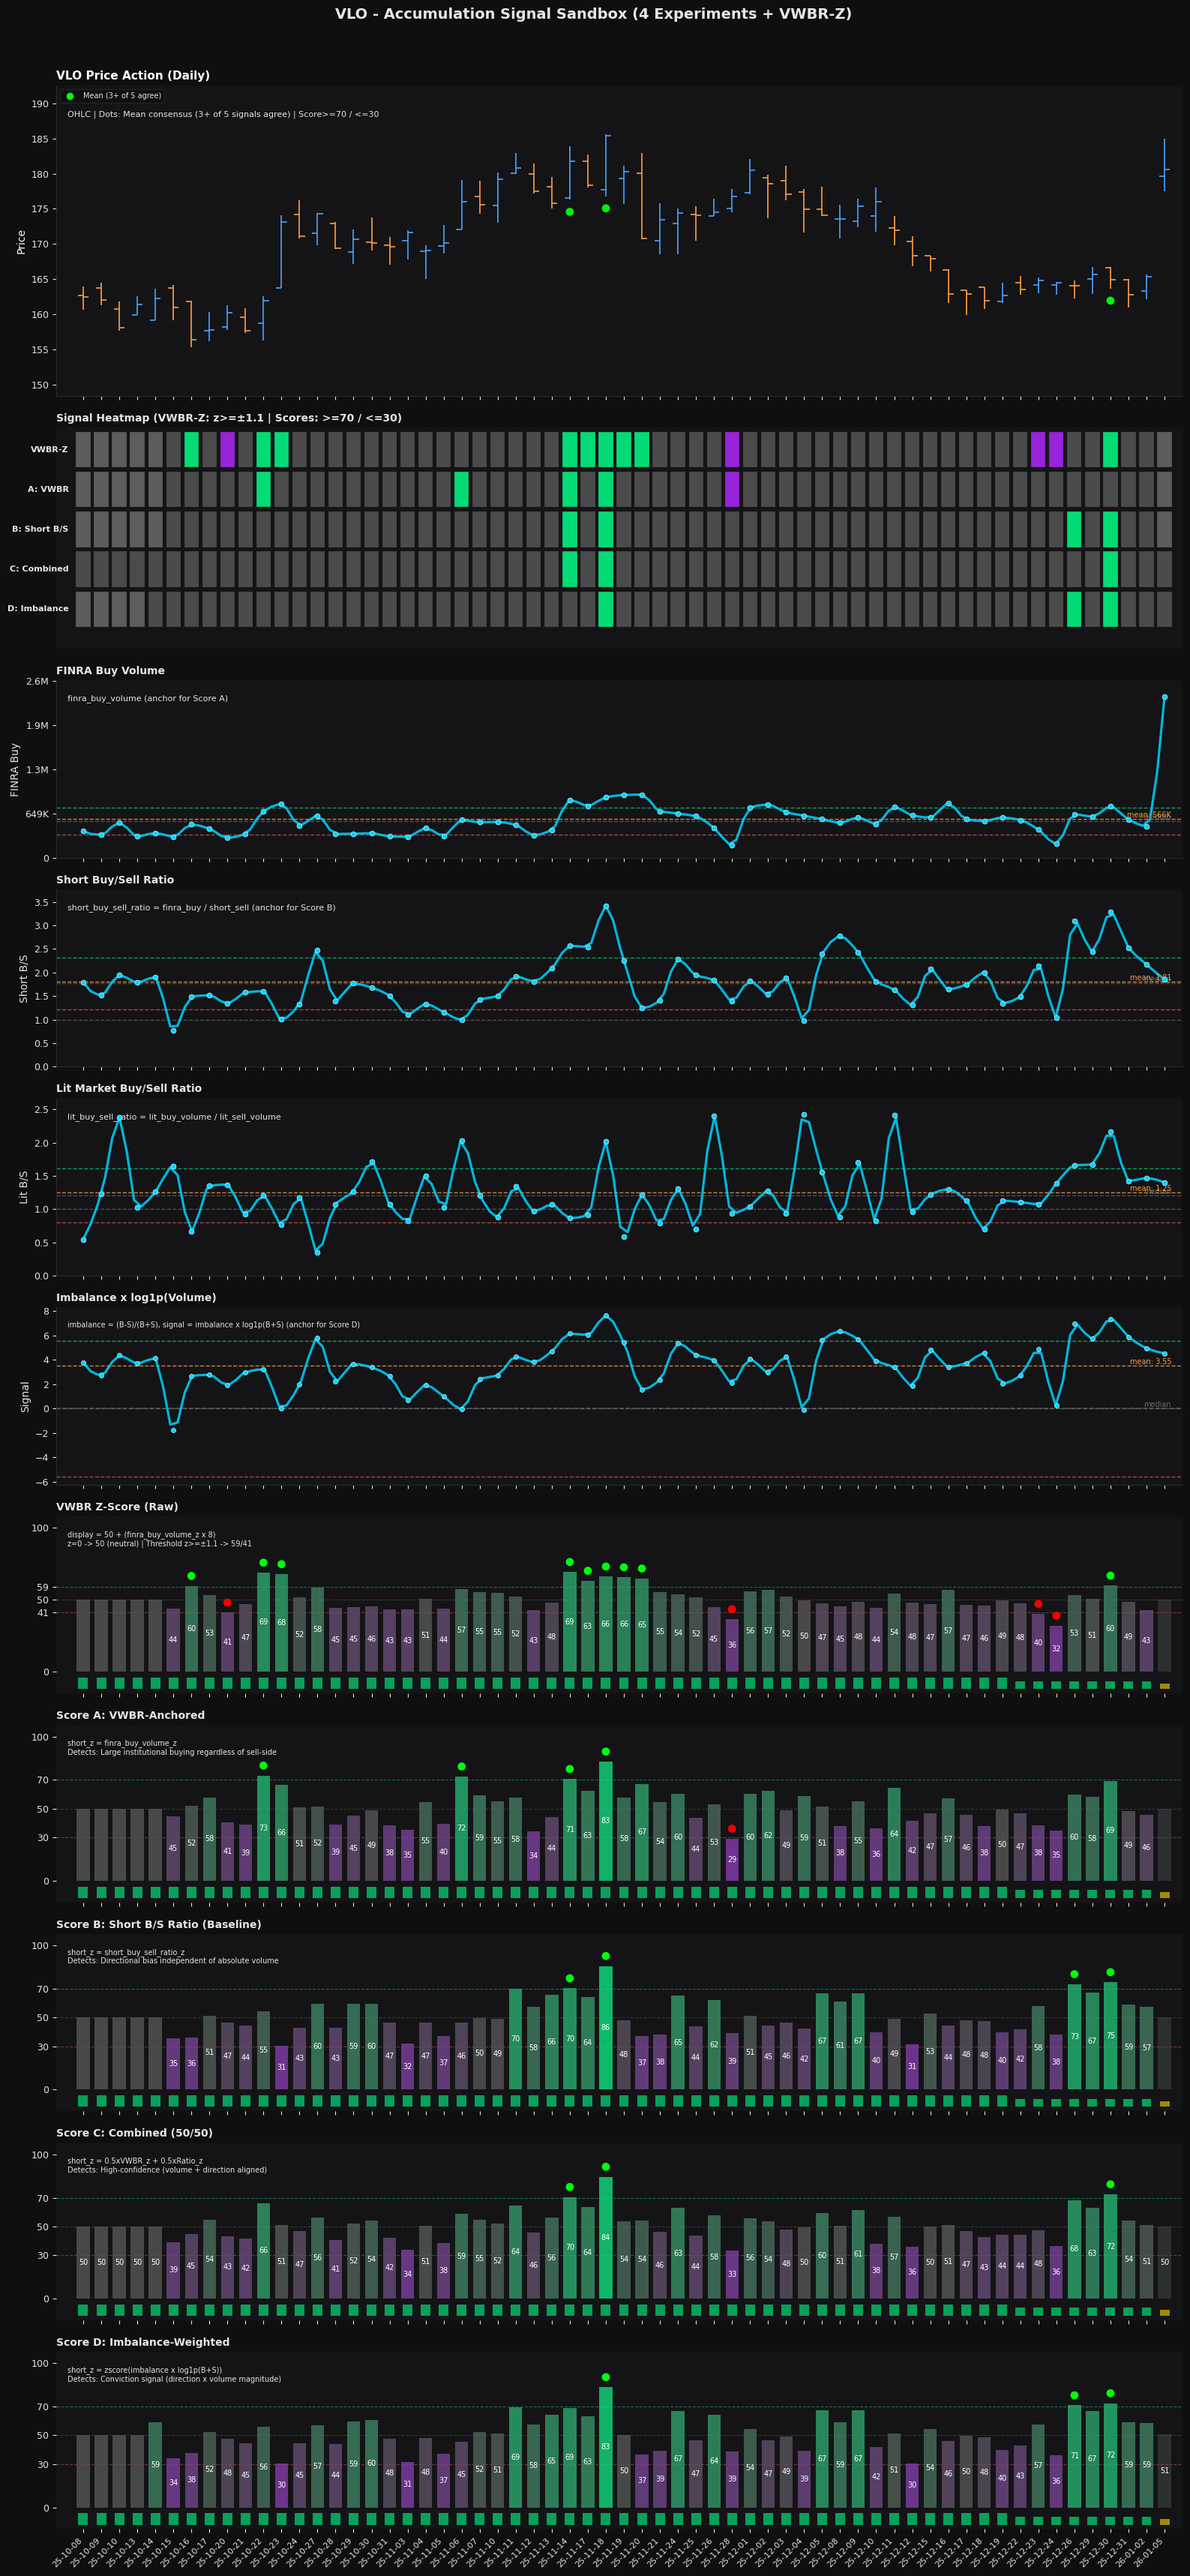

In [8]:
# Cell 4 - Main Visualization (11-Panel Chart with OHLC)
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Rectangle
from matplotlib.colors import LinearSegmentedColormap

plt.style.use('dark_background')
fig, axes = plt.subplots(
    11,
    1,
    figsize=(16, 35),
    sharex=True,
    gridspec_kw={'height_ratios': [3.5, 2.5, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]},
)
fig.patch.set_facecolor(COLORS['background'])

x = np.arange(len(df))
labels = df['date'].dt.strftime('%y-%m-%d').tolist()

# Panel 0: OHLC Price Chart with Multi-Experiment Signal Markers
ax = axes[0]
_apply_axis_style(ax)
_plot_ohlc_bars(ax, df, x)

# Calculate y-axis range and signal marker offset
y_min = df['low'].min()
y_max = df['high'].max()
if pd.isna(y_min) or pd.isna(y_max):
    y_min = df['close'].min()
    y_max = df['close'].max()
y_span = y_max - y_min if pd.notna(y_max) and pd.notna(y_min) else 0
if not y_span or y_span <= 0:
    y_span = float(df['close'].mean() or 1.0)
base_offset = y_span * 0.038  # Base vertical spacing between dot rows

# Multi-experiment signal markers on OHLC - VERTICAL stacking
# Now includes VWBR_Z at level 0, followed by A, B, C, D
OHLC_SIGNAL_SPECS = [
    {'score': 'vwbr_z_signal', 'label': 'VWBR-Z', 'exp_key': 'VWBR_Z', 'y_level': 0, 'is_zscore': True},
    {'score': 'acc_score_a', 'label': 'A: VWBR', 'exp_key': 'A', 'y_level': 1, 'is_zscore': False},
    {'score': 'acc_score_b', 'label': 'B: Ratio', 'exp_key': 'B', 'y_level': 2, 'is_zscore': False},
    {'score': 'acc_score_c', 'label': 'C: Combined', 'exp_key': 'C', 'y_level': 3, 'is_zscore': False},
    {'score': 'acc_score_d', 'label': 'D: Imbalance', 'exp_key': 'D', 'y_level': 4, 'is_zscore': False},
]

# Pre-compute VWBR Z-score buy/sell signals for use in dot displays
vwbr_z = df['finra_buy_volume_z']
vwbr_z_buy_mask = (vwbr_z >= VWBR_Z_THRESHOLD).to_numpy()
vwbr_z_sell_mask = (vwbr_z <= -VWBR_Z_THRESHOLD).to_numpy()

legend_handles_ohlc = []

# Handle OHLC_DOT_DISPLAY setting
if OHLC_DOT_DISPLAY.upper() == 'NONE':
    # No dots displayed - just show OHLC bars
    pass

elif OHLC_DOT_DISPLAY.upper() == 'MEAN':
    # Mean mode: show single dot if 3+ of 5 signals agree on direction
    # Signals: VWBR_Z (z threshold), A, B, C, D (score threshold from config)
    scores_a = df['acc_score_a'].fillna(50)
    scores_b = df['acc_score_b'].fillna(50)
    scores_c = df['acc_score_c'].fillna(50)
    scores_d = df['acc_score_d'].fillna(50)
    
    # Count how many signals indicate accumulation/distribution per bar
    # VWBR_Z uses z-score threshold, others use configurable score threshold
    accum_count = (vwbr_z_buy_mask.astype(int) +
                   (scores_a >= SCORE_BUY_THRESHOLD).astype(int) + (scores_b >= SCORE_BUY_THRESHOLD).astype(int) + 
                   (scores_c >= SCORE_BUY_THRESHOLD).astype(int) + (scores_d >= SCORE_BUY_THRESHOLD).astype(int))
    dist_count = (vwbr_z_sell_mask.astype(int) +
                  (scores_a <= SCORE_SELL_THRESHOLD).astype(int) + (scores_b <= SCORE_SELL_THRESHOLD).astype(int) + 
                  (scores_c <= SCORE_SELL_THRESHOLD).astype(int) + (scores_d <= SCORE_SELL_THRESHOLD).astype(int))
    
    # Consensus masks: 3 or more signals agree
    buy_consensus = (accum_count >= 3)
    sell_consensus = (dist_count >= 3)
    
    # Get colors from central config
    mean_colors = EXPERIMENT_DOT_COLORS['Mean']
    buy_color = mean_colors['buy']
    sell_color = mean_colors['sell']
    
    y_off = base_offset * 1.5  # Single row, slightly larger offset
    
    if buy_consensus.any():
        ax.scatter(
            x[buy_consensus],
            df.loc[buy_consensus, 'low'] - y_off,
            s=SIGNAL_MARKER_SIZE,
            c=buy_color,
            edgecolors='none',
            linewidths=0,
            zorder=6,
            alpha=0.95,
        )
    
    if sell_consensus.any():
        ax.scatter(
            x[sell_consensus],
            df.loc[sell_consensus, 'high'] + y_off,
            s=SIGNAL_MARKER_SIZE,
            c=sell_color,
            edgecolors='none',
            linewidths=0,
            zorder=6,
            alpha=0.95,
        )
    
    # Legend for Mean mode
    legend_handles_ohlc.append(
        Line2D([0], [0], marker='o', color='none', markerfacecolor=buy_color,
               markeredgecolor='none', markersize=7, label='Mean (3+ of 5 agree)')
    )

elif OHLC_DOT_DISPLAY.upper() == 'VWBR_Z':
    # VWBR Z-Score mode - show dots based on z threshold from config
    exp_colors = EXPERIMENT_DOT_COLORS['VWBR_Z']
    buy_color = exp_colors['buy']
    sell_color = exp_colors['sell']
    
    y_off = base_offset * 1.5  # Single row, slightly larger offset
    
    if vwbr_z_buy_mask.any():
        ax.scatter(
            x[vwbr_z_buy_mask],
            df.loc[vwbr_z_buy_mask, 'low'] - y_off,
            s=SIGNAL_MARKER_SIZE,
            c=buy_color,
            edgecolors='none',
            linewidths=0,
            zorder=6,
            alpha=0.9,
        )
    
    if vwbr_z_sell_mask.any():
        ax.scatter(
            x[vwbr_z_sell_mask],
            df.loc[vwbr_z_sell_mask, 'high'] + y_off,
            s=SIGNAL_MARKER_SIZE,
            c=sell_color,
            edgecolors='none',
            linewidths=0,
            zorder=6,
            alpha=0.9,
        )
    
    # Legend entry
    legend_handles_ohlc.append(
        Line2D([0], [0], marker='o', color='none', markerfacecolor=buy_color,
               markeredgecolor='none', markersize=6, label=f'VWBR-Z (±{VWBR_Z_THRESHOLD})')
    )

elif OHLC_DOT_DISPLAY.upper() in ['A', 'B', 'C', 'D']:
    # Single experiment mode - show only that experiment's dots
    exp_key = OHLC_DOT_DISPLAY.upper()
    spec = next(s for s in OHLC_SIGNAL_SPECS if s['exp_key'] == exp_key)
    
    scores = df[spec['score']]
    if not scores.isna().all():
        buy_mask = (scores >= SCORE_BUY_THRESHOLD).to_numpy()
        sell_mask = (scores <= SCORE_SELL_THRESHOLD).to_numpy()
        
        # Get colors from central config
        exp_colors = EXPERIMENT_DOT_COLORS[exp_key]
        buy_color = exp_colors['buy']
        sell_color = exp_colors['sell']
        
        y_off = base_offset * 1.5  # Single row, slightly larger offset
        
        if buy_mask.any():
            ax.scatter(
                x[buy_mask],
                df.loc[buy_mask, 'low'] - y_off,
                s=SIGNAL_MARKER_SIZE,
                c=buy_color,
                edgecolors='none',
                linewidths=0,
                zorder=6,
                alpha=0.9,
            )
        
        if sell_mask.any():
            ax.scatter(
                x[sell_mask],
                df.loc[sell_mask, 'high'] + y_off,
                s=SIGNAL_MARKER_SIZE,
                c=sell_color,
                edgecolors='none',
                linewidths=0,
                zorder=6,
                alpha=0.9,
            )
        
        # Legend entry
        legend_handles_ohlc.append(
            Line2D([0], [0], marker='o', color='none', markerfacecolor=buy_color,
                   markeredgecolor='none', markersize=6, label=spec['label'])
        )

else:
    # 'ALL' mode (default) - show all 5 signals stacked vertically (VWBR_Z, A, B, C, D)
    for spec in OHLC_SIGNAL_SPECS:
        y_off = base_offset * (spec['y_level'] + 1)  # Vertical offset based on level
        
        # Get colors from central config
        exp_colors = EXPERIMENT_DOT_COLORS[spec['exp_key']]
        buy_color = exp_colors['buy']
        sell_color = exp_colors['sell']
        
        if spec['is_zscore']:
            # VWBR Z-Score uses threshold-based detection
            buy_mask = vwbr_z_buy_mask
            sell_mask = vwbr_z_sell_mask
        else:
            # Score-based experiments use configurable thresholds
            scores = df[spec['score']]
            if scores.isna().all():
                continue
            buy_mask = (scores >= SCORE_BUY_THRESHOLD).to_numpy()
            sell_mask = (scores <= SCORE_SELL_THRESHOLD).to_numpy()
        
        # Plot buy signals (below low) - stacked vertically
        if buy_mask.any():
            ax.scatter(
                x[buy_mask],
                df.loc[buy_mask, 'low'] - y_off,
                s=SIGNAL_MARKER_SIZE - 15,
                c=buy_color,
                edgecolors='none',
                linewidths=0,
                zorder=6,
                alpha=0.9,
            )
        
        # Plot sell signals (above high) - stacked vertically
        if sell_mask.any():
            ax.scatter(
                x[sell_mask],
                df.loc[sell_mask, 'high'] + y_off,
                s=SIGNAL_MARKER_SIZE - 15,
                c=sell_color,
                edgecolors='none',
                linewidths=0,
                zorder=6,
                alpha=0.9,
            )
        
        # Build legend entry
        legend_handles_ohlc.append(
            Line2D([0], [0], marker='o', color='none', markerfacecolor=buy_color,
                   markeredgecolor='none', markersize=6, label=spec['label'])
        )

# Expand y-axis to fit all stacked dots (now 5 rows + 1 for padding)
ax.set_ylim(y_min - base_offset * 6, y_max + base_offset * 6)
ax.set_ylabel('Price', color=COLORS['white'], fontsize=10)
ax.set_title(f'{TICKER} Price Action (Daily)', color=COLORS['white'], fontsize=11, fontweight='bold', loc='left')

# Dynamic subtitle based on display mode
if OHLC_DOT_DISPLAY.upper() == 'NONE':
    subtitle = 'OHLC | Dots: disabled'
elif OHLC_DOT_DISPLAY.upper() == 'MEAN':
    subtitle = f'OHLC | Dots: Mean consensus (3+ of 5 signals agree) | Score>={SCORE_BUY_THRESHOLD} / <={SCORE_SELL_THRESHOLD}'
elif OHLC_DOT_DISPLAY.upper() == 'VWBR_Z':
    subtitle = f'OHLC | Dots: VWBR Z-Score only | z>={VWBR_Z_THRESHOLD}=Buy, z<=-{VWBR_Z_THRESHOLD}=Sell'
elif OHLC_DOT_DISPLAY.upper() in ['A', 'B', 'C', 'D']:
    subtitle = f'OHLC | Dots: Score {OHLC_DOT_DISPLAY.upper()} only | below=Buy(>={SCORE_BUY_THRESHOLD}), above=Sell(<={SCORE_SELL_THRESHOLD})'
else:
    subtitle = f'OHLC | Dots: below=Buy(>={SCORE_BUY_THRESHOLD}), above=Sell(<={SCORE_SELL_THRESHOLD}) | Stack: VWBR-Z->A->D'
ax.text(0.01, 0.92, subtitle, transform=ax.transAxes, fontsize=8, color=COLORS['text'], va='top')

# Add legend for OHLC panel (if we have handles)
if legend_handles_ohlc:
    legend = ax.legend(
        handles=legend_handles_ohlc,
        loc='upper left',
        fontsize=7,
        frameon=True,
        facecolor=COLORS['background'],
        framealpha=0.7,
        edgecolor=COLORS['grid'],
        ncol=2,
    )
    for text in legend.get_texts():
        text.set_color(COLORS['text'])


# Panel 1: Signal Heatmap (with VWBR Z-Score row at top)
ax = axes[1]
ax.set_facecolor(COLORS['panel_bg'])
for spine in ax.spines.values():
    spine.set_visible(False)

# Remove all ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# Color mapping function for score-based rows (A, B, C, D) using configurable thresholds
def get_cell_color(score):
    if pd.isna(score):
        return COLORS['neutral']
    if score >= SCORE_BUY_THRESHOLD:
        return COLORS['green']
    if score <= SCORE_SELL_THRESHOLD:
        return COLORS['purple']
    return '#555555'  # Grey for neutral

# Color mapping function for VWBR Z-Score row
def get_vwbr_z_color(z_val):
    if pd.isna(z_val):
        return COLORS['neutral']
    if z_val >= VWBR_Z_THRESHOLD:
        return COLORS['green']
    if z_val <= -VWBR_Z_THRESHOLD:
        return COLORS['purple']
    return '#555555'  # Grey for neutral

# Row labels (5 rows: VWBR-Z at top, then A, B, C, D)
row_labels = ['VWBR-Z', 'A: VWBR', 'B: Short B/S', 'C: Combined', 'D: Imbalance']

# Cell dimensions for 5 rows
cell_height = 0.16
row_gap = 0.02
y_start = 0.82  # Start position for top row

# Draw heatmap cells
for row_idx, label in enumerate(row_labels):
    y_pos = y_start - row_idx * (cell_height + row_gap)
    
    # Row label
    ax.text(-0.8, y_pos + cell_height/2, label, ha='right', va='center',
            fontsize=8, color=COLORS['text'], fontweight='bold')
    
    # Draw cells for each day
    for col_idx in range(len(df)):
        if row_idx == 0:
            # VWBR Z-Score row (top row)
            z_val = df['finra_buy_volume_z'].iloc[col_idx]
            color = get_vwbr_z_color(z_val)
        else:
            # Score rows A, B, C, D (row_idx 1-4 maps to scores 0-3)
            score_cols = ['acc_score_a', 'acc_score_b', 'acc_score_c', 'acc_score_d']
            score = df[score_cols[row_idx - 1]].iloc[col_idx]
            color = get_cell_color(score)
        
        rect = Rectangle((col_idx - 0.4, y_pos), 0.8, cell_height,
                         facecolor=color, edgecolor=COLORS['grid'], linewidth=0.3, alpha=0.85)
        ax.add_patch(rect)

ax.set_xlim(-1.5, len(df))
ax.set_ylim(0, 1.0)
ax.set_title(f'Signal Heatmap (VWBR-Z: z>=±{VWBR_Z_THRESHOLD} | Scores: >={SCORE_BUY_THRESHOLD} / <={SCORE_SELL_THRESHOLD})', color=COLORS['text'], fontsize=10, fontweight='bold', loc='left')


# Panel 2: FINRA Buy Volume (B)
ax = axes[2]
_apply_axis_style(ax)
series = df['finra_buy_volume']
mask = series.notna()
_plot_smooth_line(ax, x, series, COLORS['cyan'], mask, linewidth=MAIN_LINE_WIDTH)
ax.scatter(x[mask], series[mask], color=COLORS['cyan'], s=MARKER_SIZE, edgecolors=COLORS['white'], linewidths=0.4, zorder=5)
_set_volume_axis(ax, series)
_add_median_thresholds(ax, series, k=THRESHOLD_K)
series_mean = series.mean(skipna=True)
if not pd.isna(series_mean):
    ax.axhline(y=series_mean, color=COLORS['orange'], linestyle='--', linewidth=1.0, alpha=0.8, zorder=2)
    ax.text(0.99, series_mean, f'mean: {_format_volume(series_mean)}', transform=ax.get_yaxis_transform(), ha='right', va='bottom', fontsize=7, color=COLORS['orange'])
ax.set_ylabel('FINRA Buy', color=COLORS['text'])
ax.set_title('FINRA Buy Volume', color=COLORS['text'], fontsize=10, fontweight='bold', loc='left')
ax.text(0.01, 0.92, 'finra_buy_volume (anchor for Score A)', transform=ax.transAxes, fontsize=8, color=COLORS['text'], va='top')


# Panel 3: Short Buy/Sell Ratio
ax = axes[3]
_apply_axis_style(ax)
series = df['short_buy_sell_ratio']
mask = series.notna()
_plot_smooth_line(ax, x, series, COLORS['cyan'], mask, linewidth=MAIN_LINE_WIDTH)
ax.scatter(x[mask], series[mask], color=COLORS['cyan'], s=MARKER_SIZE, edgecolors=COLORS['white'], linewidths=0.4, zorder=5)
_set_ratio_axis(ax, series)
ax.axhline(1.0, color=COLORS['neutral'], linestyle='--', linewidth=1.0, alpha=0.7)
_add_median_thresholds(ax, series, k=THRESHOLD_K)
series_mean = series.mean(skipna=True)
if not pd.isna(series_mean):
    ax.axhline(y=series_mean, color=COLORS['orange'], linestyle='--', linewidth=1.0, alpha=0.8, zorder=2)
    ax.text(0.99, series_mean, f'mean: {series_mean:.2f}', transform=ax.get_yaxis_transform(), ha='right', va='bottom', fontsize=7, color=COLORS['orange'])
ax.set_ylabel('Short B/S', color=COLORS['text'])
ax.set_title('Short Buy/Sell Ratio', color=COLORS['text'], fontsize=10, fontweight='bold', loc='left')
ax.text(0.01, 0.92, 'short_buy_sell_ratio = finra_buy / short_sell (anchor for Score B)', transform=ax.transAxes, fontsize=8, color=COLORS['text'], va='top')


# Panel 4: Lit Buy/Sell Ratio
ax = axes[4]
_apply_axis_style(ax)
series = df['lit_buy_sell_ratio']
mask = series.notna()
_plot_smooth_line(ax, x, series, COLORS['cyan'], mask, linewidth=MAIN_LINE_WIDTH)
ax.scatter(x[mask], series[mask], color=COLORS['cyan'], s=MARKER_SIZE, edgecolors=COLORS['white'], linewidths=0.4, zorder=5)
_set_ratio_axis(ax, series)
ax.axhline(1.0, color=COLORS['neutral'], linestyle='--', linewidth=1.0, alpha=0.7)
_add_median_thresholds(ax, series, k=THRESHOLD_K)
series_mean = series.mean(skipna=True)
if not pd.isna(series_mean):
    ax.axhline(y=series_mean, color=COLORS['orange'], linestyle='--', linewidth=1.0, alpha=0.8, zorder=2)
    ax.text(0.99, series_mean, f'mean: {series_mean:.2f}', transform=ax.get_yaxis_transform(), ha='right', va='bottom', fontsize=7, color=COLORS['orange'])
ax.set_ylabel('Lit B/S', color=COLORS['text'])
ax.set_title('Lit Market Buy/Sell Ratio', color=COLORS['text'], fontsize=10, fontweight='bold', loc='left')
ax.text(0.01, 0.92, 'lit_buy_sell_ratio = lit_buy_volume / lit_sell_volume', transform=ax.transAxes, fontsize=8, color=COLORS['text'], va='top')


# Panel 5: Imbalance Signal (for Score D)
ax = axes[5]
_apply_axis_style(ax)
series = df['imbalance_signal']
mask = series.notna()
_plot_smooth_line(ax, x, series, COLORS['cyan'], mask, linewidth=MAIN_LINE_WIDTH)
ax.scatter(x[mask], series[mask], color=COLORS['cyan'], s=MARKER_SIZE - 5, edgecolors=COLORS['white'], linewidths=0.4, zorder=5)
ax.axhline(0.0, color=COLORS['neutral'], linestyle='--', linewidth=1.2, alpha=0.7)
_add_median_thresholds(ax, series, k=THRESHOLD_K, center_override=0.0)
series_mean = series.mean(skipna=True)
if not pd.isna(series_mean):
    ax.axhline(y=series_mean, color=COLORS['orange'], linestyle='--', linewidth=1.0, alpha=0.8, zorder=2)
    ax.text(0.99, series_mean, f'mean: {series_mean:.2f}', transform=ax.get_yaxis_transform(), ha='right', va='bottom', fontsize=7, color=COLORS['orange'])
ax.set_ylabel('Signal', color=COLORS['text'])
ax.set_title('Imbalance x log1p(Volume)', color=COLORS['text'], fontsize=10, fontweight='bold', loc='left')
ax.text(0.01, 0.92, 'imbalance = (B-S)/(B+S), signal = imbalance x log1p(B+S) (anchor for Score D)', transform=ax.transAxes, fontsize=7, color=COLORS['text'], va='top')


# Shared dot sources for all score panels
dot_sources = {
    'current': df['acc_score_b'],  # Use Score B as "current" reference
    'option_a': df['acc_score_a'],
    'option_b': df['acc_score_c'],
}

# =============================================================================
# Panel 6: VWBR Z-Score Histogram (NEW - Raw Z-Score Display)
# =============================================================================
ax = axes[6]
ax.set_facecolor(COLORS['panel_bg'])
ax.tick_params(colors=COLORS['text'], labelsize=9)
for spine in ax.spines.values():
    spine.set_visible(False)

# Convert z-scores to display scale: z=0 maps to 50
vwbr_z_display = 50.0 + (df['finra_buy_volume_z'] * VWBR_Z_SCALE_FACTOR)
vwbr_z_display = vwbr_z_display.clip(0, 100)

# Custom score panel for VWBR Z-Score with z-threshold-based dots
score_cmap = LinearSegmentedColormap.from_list(
    'score_cmap',
    [
        (0.0, COLORS['purple']),
        (0.5, '#555555'),
        (1.0, COLORS['green']),
    ],
)

scores_filled = vwbr_z_display.fillna(50)
conf_filled = df['confidence'].fillna(0.5)

# Calculate display thresholds for reference lines
z_buy_display = 50 + (VWBR_Z_THRESHOLD * VWBR_Z_SCALE_FACTOR)  # e.g., 61
z_sell_display = 50 - (VWBR_Z_THRESHOLD * VWBR_Z_SCALE_FACTOR)  # e.g., 39
buy_line = z_buy_display / 100.0
sell_line = z_sell_display / 100.0

for xi, score, conf, score_raw in zip(x, scores_filled, conf_filled, vwbr_z_display):
    norm_score = np.clip(score / 100.0, 0, 1)
    dev = norm_score - 0.5
    norm_score = 0.5 + np.sign(dev) * (abs(dev) ** 0.85)
    norm_score = np.clip(norm_score, 0, 1)
    bar_color = score_cmap(norm_score)
    alpha = 0.8 if conf >= 0.6 else 0.4
    bar_height = score / 100.0
    ax.bar(xi, bar_height, bottom=0, color=bar_color, alpha=alpha, width=0.72, zorder=2)

    if not pd.isna(score_raw):
        label_y = max(bar_height / 2, 0.12)
        ax.text(
            xi,
            label_y,
            f'{score:.0f}',
            ha='center',
            va='center',
            fontsize=7,
            color=COLORS['white'],
            zorder=4,
        )

    # Confidence bar
    conf_height = 0.08 * conf
    if conf >= 0.7:
        conf_color = COLORS['green']
    elif conf >= 0.4:
        conf_color = COLORS['yellow']
    else:
        conf_color = COLORS['red']
    ax.bar(xi, conf_height, bottom=-0.12, color=conf_color, alpha=0.6, width=0.54, zorder=3)

# Reference lines at z-threshold display values
ax.axhline(y=sell_line, color=COLORS['red'], linestyle='--', linewidth=0.8, alpha=0.4, zorder=1)
ax.axhline(y=0.50, color=COLORS['neutral'], linestyle='--', linewidth=0.8, alpha=0.4, zorder=1)
ax.axhline(y=buy_line, color=COLORS['green'], linestyle='--', linewidth=0.8, alpha=0.4, zorder=1)
ax.set_ylim(-0.15, 1.08)
ax.set_yticks([0, sell_line, 0.5, buy_line, 1.0])
ax.set_yticklabels(['0', f'{z_sell_display:.0f}', '50', f'{z_buy_display:.0f}', '100'])
ax.set_title('VWBR Z-Score (Raw)', color=COLORS['text'], fontsize=10, fontweight='bold', loc='left')

# Signal dots based on raw z-score thresholds (not display values)
dot_pad = 0.07
accum_color = EXPERIMENT_DOT_COLORS['VWBR_Z']['buy']
dist_color = EXPERIMENT_DOT_COLORS['VWBR_Z']['sell']

if vwbr_z_buy_mask.any():
    y_vals = (vwbr_z_display[vwbr_z_buy_mask] / 100.0) + dot_pad
    y_vals = np.minimum(y_vals, 1.04)
    ax.scatter(
        x[vwbr_z_buy_mask],
        y_vals.to_numpy(),
        s=60,
        c=accum_color,
        edgecolors='none',
        linewidths=0.0,
        zorder=6,
    )
if vwbr_z_sell_mask.any():
    y_vals = (vwbr_z_display[vwbr_z_sell_mask] / 100.0) + dot_pad
    y_vals = np.minimum(y_vals, 1.04)
    ax.scatter(
        x[vwbr_z_sell_mask],
        y_vals.to_numpy(),
        s=60,
        c=dist_color,
        edgecolors='none',
        linewidths=0.0,
        zorder=6,
    )

ax.text(0.01, 0.92, 
        f'display = 50 + (finra_buy_volume_z x {VWBR_Z_SCALE_FACTOR})\nz=0 -> 50 (neutral) | Threshold z>=±{VWBR_Z_THRESHOLD} -> {z_buy_display:.0f}/{z_sell_display:.0f}',
        transform=ax.transAxes, fontsize=7, color=COLORS['text'], va='top')


# Panel 7: Score A - VWBR (finra_buy_volume_z)
ax = axes[7]
ax.set_facecolor(COLORS['panel_bg'])
ax.tick_params(colors=COLORS['text'], labelsize=9)
for spine in ax.spines.values():
    spine.set_visible(False)
_plot_score_panel(ax, x, df['acc_score_a'], df['confidence'], 'Score A: VWBR-Anchored', DOT_MODE, dot_sources, 
                  force_self_dots=True, 
                  dot_accum_color=EXPERIMENT_DOT_COLORS['A']['buy'], 
                  dot_dist_color=EXPERIMENT_DOT_COLORS['A']['sell'])
ax.text(0.01, 0.92, 'short_z = finra_buy_volume_z\nDetects: Large institutional buying regardless of sell-side', transform=ax.transAxes, fontsize=7, color=COLORS['text'], va='top')


# Panel 8: Score B - Short Buy/Sell Ratio (Production Baseline)
ax = axes[8]
ax.set_facecolor(COLORS['panel_bg'])
ax.tick_params(colors=COLORS['text'], labelsize=9)
for spine in ax.spines.values():
    spine.set_visible(False)
_plot_score_panel(ax, x, df['acc_score_b'], df['confidence'], 'Score B: Short B/S Ratio (Baseline)', DOT_MODE, dot_sources, 
                  force_self_dots=True, 
                  dot_accum_color=EXPERIMENT_DOT_COLORS['B']['buy'], 
                  dot_dist_color=EXPERIMENT_DOT_COLORS['B']['sell'])
ax.text(0.01, 0.92, 'short_z = short_buy_sell_ratio_z\nDetects: Directional bias independent of absolute volume', transform=ax.transAxes, fontsize=7, color=COLORS['text'], va='top')


# Panel 9: Score C - Combined (50/50 Blend)
ax = axes[9]
ax.set_facecolor(COLORS['panel_bg'])
ax.tick_params(colors=COLORS['text'], labelsize=9)
for spine in ax.spines.values():
    spine.set_visible(False)
_plot_score_panel(ax, x, df['acc_score_c'], df['confidence'], 'Score C: Combined (50/50)', DOT_MODE, dot_sources, 
                  force_self_dots=True, 
                  dot_accum_color=EXPERIMENT_DOT_COLORS['C']['buy'], 
                  dot_dist_color=EXPERIMENT_DOT_COLORS['C']['sell'])
ax.text(0.01, 0.92, 'short_z = 0.5xVWBR_z + 0.5xRatio_z\nDetects: High-confidence (volume + direction aligned)', transform=ax.transAxes, fontsize=7, color=COLORS['text'], va='top')


# Panel 10: Score D - Exploratory (Imbalance-Weighted)
ax = axes[10]
ax.set_facecolor(COLORS['panel_bg'])
ax.tick_params(colors=COLORS['text'], labelsize=9)
for spine in ax.spines.values():
    spine.set_visible(False)
_plot_score_panel(ax, x, df['acc_score_d'], df['confidence'], 'Score D: Imbalance-Weighted', DOT_MODE, dot_sources, 
                  force_self_dots=True, 
                  dot_accum_color=EXPERIMENT_DOT_COLORS['D']['buy'], 
                  dot_dist_color=EXPERIMENT_DOT_COLORS['D']['sell'])
ax.text(0.01, 0.92, 'short_z = zscore(imbalance x log1p(B+S))\nDetects: Conviction signal (direction x volume magnitude)', transform=ax.transAxes, fontsize=7, color=COLORS['text'], va='top')


# Set x-axis labels
axes[-1].set_xticks(x)
axes[-1].set_xticklabels(labels, rotation=45, ha='right', fontsize=8)

fig.suptitle(f'{TICKER} - Accumulation Signal Sandbox (4 Experiments + VWBR-Z)', color=COLORS['text'], fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()